# Split Learning and Label Leakage

In [1]:
import secretflow as sf
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sf.init(['client', 'server'], address='local')
client, server = sf.PYU('client'), sf.PYU('server')

2023-10-07 09:46:54,585	INFO worker.py:1538 -- Started a local Ray instance.


In [2]:
import sys

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve, auc

from attack.labelleakage import NormAttackSplitNNManager
from collaborative.splitnn import SplitNNAPI, SplitNNClient
from utils.utils import NumpyDataset

(raylet) [2023-10-07 09:47:03,504 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29714096128; capacity: 3936380534784. Object creation will fail if spilling is required.


In [4]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
def zero_activation(x):
    return tf.zeros_like(x)

In [5]:
def create_first_net(input_dim, hidden_dim, name='first_net'):
    # Create model
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        import tensorflow as tf
        model = keras.Sequential(
            [
                keras.Input(shape=input_dim),
                layers.Dense(hidden_dim // 2, activation="relu"),
                layers.Dense(hidden_dim, activation="relu"),
            ]
        )
        # Compile model
        model.summary()
        learning_rate = 1e-3  # 设置学习率
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=["accuracy", tf.keras.metrics.AUC()])
        return model
    return create_model

def create_zero_net(input_dim, hidden_dim, name='zero_net'):
    # Create model
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        import tensorflow as tf
        model = keras.Sequential(
            [
                keras.Input(shape=input_dim),
                layers.Dense(hidden_dim, activation="relu"),
            ]
        )
        # Compile model
        model.summary()
        learning_rate = 1e-3  # 设置学习率
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=["accuracy", tf.keras.metrics.AUC()])
        return model
    return create_model

In [6]:
def create_fuse_model(input_dim_1, input_dim_2, output_dim, party_nums, name='fuse_model'):
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        import tensorflow as tf
        # input
        input_layers = []
        # for i in range(party_nums):
        input_layers.append(keras.Input(input_dim_1,))
        input_layers.append(keras.Input(input_dim_2,))

        merged_layer = layers.concatenate(input_layers)
        output = layers.Dense(output_dim, activation='sigmoid')(merged_layer)
        # output = layers.Dense(output_dim, activation='relu')(fuse_layer)

        model = keras.Model(inputs=input_layers, outputs=output)
        model.summary()
        
        learning_rate = 1e-3  # 设置学习率
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=["accuracy",tf.keras.metrics.AUC()])
        return model
    return create_model

## Parameters and Pre-processing

In [7]:
import pandas as pd
import numpy as np
from secretflow.utils.simulation.datasets import dataset

raw_df = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
)
raw_df_neg = raw_df[raw_df["Class"] == 0]
raw_df_pos = raw_df[raw_df["Class"] == 1]

down_df_neg = raw_df_neg  # .sample(40000)
down_df = pd.concat([down_df_neg, raw_df_pos])

neg, pos = np.bincount(down_df["Class"])
total = neg + pos
print(
    "Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n".format(
        total, pos, 100 * pos / total
    )
)

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



(raylet) [2023-10-07 09:47:13,513 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29714046976; capacity: 3936380534784. Object creation will fail if spilling is required.


In [8]:
cleaned_df = down_df.copy()
# You don't want the `Time` column.
cleaned_df.pop("Time")
# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001  # 0 => 0.1¢
cleaned_df["Log Ammount"] = np.log(cleaned_df.pop("Amount") + eps)

In [9]:
client_data_index = [col for col in cleaned_df.columns if col != "Class" and col != "V1" and col != "V2" and col != "V3" and col != "V4"]
client_data = cleaned_df[client_data_index]
client_data

,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log Ammount
0,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008105
1,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.989913
2,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.936641
3,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.816249
4,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.248367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,2.115795,-5.417424,-1.235123,-6.665177,...,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,5.966149
280143,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,2.858466,-3.096915,-0.792532,-5.210141,...,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,-0.273122
280149,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,1.794969,-2.775022,-0.418950,-4.057162,...,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,4.355310
281144,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,1.933520,-5.030465,-1.127455,-6.416628,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,5.501262


In [10]:
server_data = cleaned_df[["V1", "V2", "V3", "V4", "Class"]]
server_data

,V1,V2,V3,V4,Class
0,-1.359807,-0.072781,2.536347,1.378155,0
1,1.191857,0.266151,0.166480,0.448154,0
2,-1.358354,-1.340163,1.773209,0.379780,0
3,-0.966272,-0.185226,1.792993,-0.863291,0
4,-1.158233,0.877737,1.548718,0.403034,0
...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,1
280143,1.378559,1.289381,-5.004247,1.411850,1
280149,-0.676143,1.126366,-2.213700,0.468308,1
281144,-3.113832,0.585864,-5.399730,1.817092,1


In [11]:
df = pd.concat([client_data, server_data], axis=1)
df = df[-284160:]
df

,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,...,V25,V26,V27,V28,Log Ammount,V1,V2,V3,V4,Class
649,-0.252045,-0.392240,-0.047177,0.041339,-0.069318,0.169913,0.947708,0.417596,-0.798841,0.679509,...,0.352684,-0.625998,0.013681,0.015683,2.301685,1.196288,0.217099,0.402596,0.921664,0
650,-0.441560,0.310187,-0.559948,0.349136,0.332922,0.220886,0.826773,-0.257591,-1.961189,0.728867,...,0.420079,-0.213097,0.040658,0.010599,2.302685,1.130024,-0.060944,0.662074,1.033990,0
651,-2.807266,0.726236,2.737602,-0.933999,-2.413730,0.796625,-0.878071,-1.045044,1.249929,-0.960840,...,0.479636,-0.098230,0.053527,-0.408050,6.449524,-0.789890,-1.379371,0.171334,-1.636756,0
652,-0.258357,-0.519342,-0.035458,-0.117824,1.267125,-1.068542,-0.638446,0.352485,0.060428,0.332823,...,0.525568,0.084212,-0.001621,0.011866,4.218640,1.219725,-0.481149,-0.324351,-1.552562,0
653,-0.400077,-0.677461,0.778466,-0.303557,-0.630844,0.230737,0.015912,0.549293,1.123662,0.146946,...,-1.276798,-0.461654,0.205261,0.250664,4.007170,0.058501,1.058661,1.076857,1.589043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,2.115795,-5.417424,-1.235123,-6.665177,...,0.537503,0.788395,0.292680,0.147968,5.966149,-1.927883,1.125653,-4.518331,1.749293,1
280143,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,2.858466,-3.096915,-0.792532,-5.210141,...,0.521875,0.739467,0.389152,0.186637,-0.273122,1.378559,1.289381,-5.004247,1.411850,1
280149,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,1.794969,-2.775022,-0.418950,-4.057162,...,-0.739695,0.471111,0.385107,0.194361,4.355310,-0.676143,1.126366,-2.213700,0.468308,1
281144,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,1.933520,-5.030465,-1.127455,-6.416628,...,-0.328168,0.606116,0.884876,-0.253700,5.501262,-3.113832,0.585864,-5.399730,1.817092,1


In [12]:
from secretflow.data.split import train_test_split
from secretflow.ml.nn import SLModel
spu = sf.SPU(sf.utils.testing.cluster_def(['client', 'server']))

In [13]:
from secretflow.utils.simulation.data.dataframe import create_df
data = create_df(
        source=df,
        parts={client: (0, 25), server: (25, 29)},  
        axis=1,
        shuffle=False,
    )
label = create_df(
        source=df,
        parts={server: (29, 30)},
        axis=1,
        shuffle=False,
    )

In [14]:
print(f"label= {type(label)},\ndata = {type(data)}")

label= <class 'secretflow.data.vertical.dataframe.VDataFrame'>,
data = <class 'secretflow.data.vertical.dataframe.VDataFrame'>


In [15]:
# 确认VDataFrame存储无误
# print(data.to_csv({server: "server"}))
# print(data.to_csv({client: "client"}))

In [16]:
from secretflow.preprocessing.scaler import MinMaxScaler, StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)
# data = data.clip(-5,5)  # 由于sf中没有实现clip函数，因此先注释掉

(_run pid=864147) /home/kyzhang/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
(_run pid=864147)   warnings.warn(
(_run pid=863969) /home/kyzhang/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
(_run pid=863969)   warnings.warn(


In [17]:
random_state = 1234
train_data,test_data = train_test_split(data, train_size=0.8, random_state=random_state)
train_label,test_label = train_test_split(label, train_size=0.8, random_state=random_state)

In [18]:
train_label.shape

(raylet) [2023-10-07 09:47:23,521 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29713969152; capacity: 3936380534784. Object creation will fail if spilling is required.


(227328, 1)

## Split Learning

### 实例化模型

In [19]:
hidden_dim_1 = 28
hidden_dim_2 = 4
# Create FirstNet model
client_builder = create_first_net(input_dim=25, hidden_dim=hidden_dim_1)
# client_model = first_net_builder()

# Create ZeroNet model
server_zero_builder = create_zero_net(input_dim=4, hidden_dim=hidden_dim_2)
# server_zero_model = zero_net_builder()

In [20]:
fuse_builder = create_fuse_model(input_dim_1=hidden_dim_1, input_dim_2=hidden_dim_2, party_nums=2, output_dim=1)
# fuse_net_model = fuse_net_builder()

In [21]:
base_model_dict = {
    client:   client_builder,
    server:   server_zero_builder
}

### 增加DP模块

In [22]:
from secretflow.security.privacy import DPStrategy, LabelDP
from secretflow.security.privacy.mechanism.tensorflow import GaussianEmbeddingDP

# Define DP operations
train_batch_size = 1024
gaussian_embedding_dp = GaussianEmbeddingDP(
    noise_multiplier=0.5,
    l2_norm_clip=1.0,
    batch_size=train_batch_size,
    num_samples=train_data.values.partition_shape()[server][0],
    is_secure_generator=False,
)
label_dp = LabelDP(eps=64.0)
dp_strategy_server = DPStrategy(label_dp=label_dp)
dp_strategy_client = DPStrategy(embedding_dp=gaussian_embedding_dp)
dp_strategy_dict = {client: dp_strategy_client, server: dp_strategy_server}
dp_spent_step_freq = 10

In [23]:
sl_model = SLModel(
    base_model_dict=base_model_dict,
    device_y=server,
    model_fuse=fuse_builder)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party client.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party server.


### 训练SplitNN

In [24]:
from attack.labelleakage import NormAttackSplitNNManager_sf
manager = NormAttackSplitNNManager_sf(device="cpu")
NormAttackSplitNNAPI = manager.attach(SLModel)
normattacksplitnn = NormAttackSplitNNAPI(
    base_model_dict=base_model_dict,
    device_y=server,
    model_fuse=fuse_builder)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party client.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party server.


In [25]:
train_batch_size = 1024
epochs=10
history = normattacksplitnn.fit(train_data,
             train_label,
             validation_data=(test_data,test_label),
             epochs=epochs,
             batch_size=train_batch_size,
             shuffle=True,
             verbose=1,
             validation_freq=1,
             dp_spent_step_freq=dp_spent_step_freq,)

INFO:root:SL Train Params: {'self': <attack.labelleakage.normattack.attach_normattack_to_splitnn_sf.<locals>.NormAttackSplitNNWrapper_sf object at 0x7f617a286ca0>, 'x': VDataFrame(partitions={PYURuntime(client): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f6182ee4d90>), PYURuntime(server): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f617aba1370>)}, aligned=True), 'y': VDataFrame(partitions={PYURuntime(server): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f617aba1bb0>)}, aligned=True), 'batch_size': 1024, 'epochs': 10, 'verbose': 1, 'callbacks': None, 'validation_data': (VDataFrame(partitions={PYURuntime(client): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f617ab7bfa0>), PYURuntime(server): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f617aba12b0>)}, aligned=True), VDataFrame(partitions={PYURuntime(server): Partition(data=<secretflow.device.device.pyu.PYUObject object at

(PYUSLTFModel pid=874475) Model: "sequential"
(PYUSLTFModel pid=874475) _________________________________________________________________
(PYUSLTFModel pid=874475)  Layer (type)                Output Shape              Param #   
(PYUSLTFModel pid=874475) =================================================================
(PYUSLTFModel pid=874475)  dense (Dense)               (None, 14)                364       
(PYUSLTFModel pid=874475)                                                                  
(PYUSLTFModel pid=874475)  dense_1 (Dense)             (None, 28)                420       
(PYUSLTFModel pid=874475)                                                                  
(PYUSLTFModel pid=874475) =================================================================
(PYUSLTFModel pid=874475) Total params: 784
(PYUSLTFModel pid=874475) Trainable params: 784
(PYUSLTFModel pid=874475) Non-trainable params: 0
(PYUSLTFModel pid=874475) __________________________________________________

(PYUSLTFModel pid=874477) 2023-10-07 09:47:41.824427: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(PYUSLTFModel pid=874477) Model: "sequential"
(PYUSLTFModel pid=874477) _________________________________________________________________
(PYUSLTFModel pid=874477)  Layer (type)                Output Shape              Param #   
(PYUSLTFModel pid=874477) =================================================================
(PYUSLTFModel pid=874477)  dense (Dense)               (None, 4)                 20        
(PYUSLTFModel pid=874477)                                                                  
(PYUSLTFModel pid=874477) =================================================================
(PYUSLTFModel pid=874477) Total params: 20
(PYUSLTFModel pid=874477) Trainable params: 20
(PYUSLTFModel pid=874477) Non-trainable params: 0
(PYUSLTFModel pid=874477) _________________________________________________________________
(PYUSLTFModel pid=874477) Model: "model"
(PYUSLTFModel pid=874477) __________________________________________________________________________________________________
(PYU

(raylet) [2023-10-07 09:47:43,539 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29713563648; capacity: 3936380534784. Object creation will fail if spilling is required.
(PYUSLTFModel pid=874509) 2023-10-07 09:47:47.013845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(PYUSLTFModel pid=874509) Model: "sequential"
(PYUSLTFModel pid=874509) _________________________________________________________________
(PYUSLTFModel pid=874509)  Layer (type)                Output Shape              Param #   
(PYUSLTFModel pid=874509) =================================================================
(PYUSLTFModel pid=874509)  dense (Dense)               (None, 4)                 20        
(PYUSLTFModel pid=874509)                                                                  
(PYUSLTFModel pid=874509) =================================================================
(PYUSLTFModel pid=874509) Total params: 20
(PYUSLTFModel pid=874509) Trainable params: 20
(PYUSLTFModel pid=874509) Non-trainable params: 0
(PYUSLTFModel pid=874509) _________________________________________________________________
(PYUSLTFModel pid=874509) Model: "model"
(PYUSLTFModel pid=874509) __________________________________________________________________________________________________
(PYU

  0%|          | 0/222 [00:00<?, ?it/s](raylet) [2023-10-07 09:47:53,545 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29713526784; capacity: 3936380534784. Object creation will fail if spilling is required.
(raylet) [2023-10-07 09:48:03,551 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29713498112; capacity: 3936380534784. Object creation will fail if spilling is required.
(raylet) [2023-10-07 09:48:13,557 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29713473536; capacity: 3936380534784. Object creation will fail if spilling is required.
(raylet) [2023-10-07 09:48:23,564 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space

### 评估SplitNN

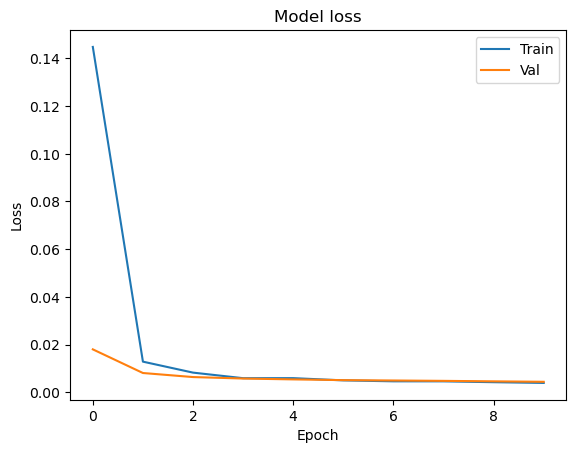

In [26]:
# Plot the change of loss during training
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper right')
plt.show()

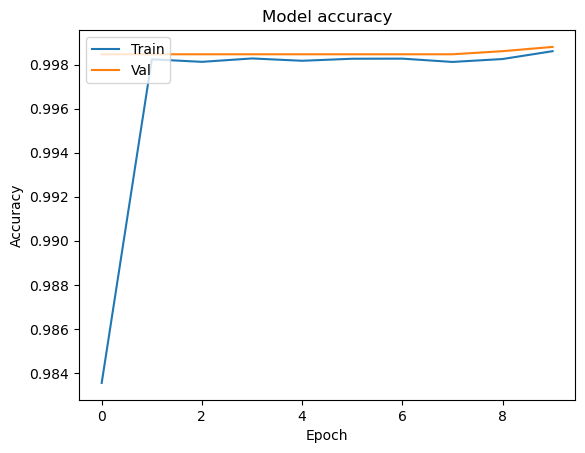

In [27]:
# Plot the change of accuracy during training
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

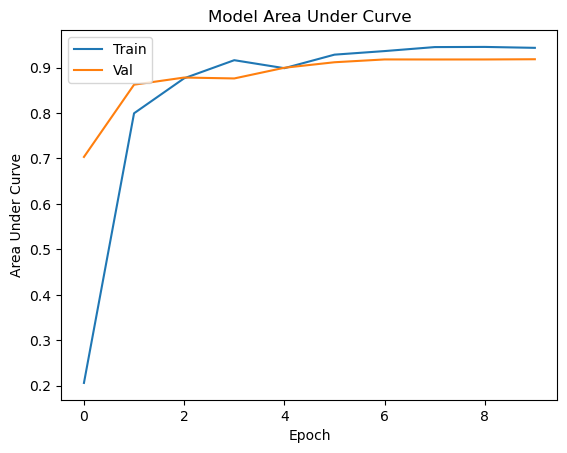

In [28]:
# Plot the Area Under Curve(AUC) of loss during training
plt.plot(history['train_auc_1'])
plt.plot(history['val_auc_1'])
plt.title('Model Area Under Curve')
plt.ylabel('Area Under Curve')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Norm Attack实现

In [29]:
g_norms = normattacksplitnn.attack_grad(train_data,
             train_label,
             validation_data=(test_data,test_label),
             epochs=epochs,
             batch_size=train_batch_size,
             shuffle=True,
             verbose=1,
             validation_freq=1,)
             # dp_spent_step_freq=dp_spent_step_freq,)

INFO:root:SL Train Params: {'self': <attack.labelleakage.normattack.attach_normattack_to_splitnn_sf.<locals>.NormAttackSplitNNWrapper_sf object at 0x7f617a286ca0>, 'x': VDataFrame(partitions={PYURuntime(client): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f6182ee4d90>), PYURuntime(server): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f617aba1370>)}, aligned=True), 'y': VDataFrame(partitions={PYURuntime(server): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f617aba1bb0>)}, aligned=True), 'batch_size': 1024, 'epochs': 10, 'verbose': 1, 'callbacks': None, 'validation_data': (VDataFrame(partitions={PYURuntime(client): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f617ab7bfa0>), PYURuntime(server): Partition(data=<secretflow.device.device.pyu.PYUObject object at 0x7f617aba12b0>)}, aligned=True), VDataFrame(partitions={PYURuntime(server): Partition(data=<secretflow.device.device.pyu.PYUObject object at

### Norm Attack评估

In [30]:
import jax.numpy as jnp
# jnp.sum(g_norms,axis=1)
normattack_pred = jnp.concatenate(g_norms)
normattack_pred.shape

(227328,)

In [31]:
import jax
ground_label = sf.reveal(train_label.values.partitions[server])
ground_label = ground_label.flatten()
ground_label.shape

(227328,)

In [32]:
# 将 JAX 数组转换为 NumPy 数组
y_true_numpy = ground_label.tolist()
y_pred_numpy = normattack_pred.tolist()

# 计算 ROC-AUC
roc_auc = roc_auc_score(y_true_numpy, y_pred_numpy)

In [33]:
roc_auc

0.4830404592018297

(raylet) [2023-10-07 09:57:43,979 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29702074368; capacity: 3936380534784. Object creation will fail if spilling is required.
(raylet) [2023-10-07 09:57:53,987 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29701976064; capacity: 3936380534784. Object creation will fail if spilling is required.
(raylet) [2023-10-07 09:58:03,995 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29701890048; capacity: 3936380534784. Object creation will fail if spilling is required.
(raylet) [2023-10-07 09:58:14,000 E 863006 863057] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-10-07_09-46-51_462254_862338 is over 95% full, available space: 29701857280; capacity: 3936380534784.